# Training on 25,000 events. Testing on the RAMP set.

In [1]:
!nvidia-smi

Mon Aug 28 13:45:55 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   28C    P8     9W / 180W |    434MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   29C    P8     9W / 180W |      2MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
%matplotlib notebook
import importlib
import numpy as np
import pandas as pd
import keras
from keras.layers import TimeDistributed, Dense, Dropout, GRU, Bidirectional
from keras.models import Sequential
from tracker import extractor as ext, utils, metrics, visuals

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0B:00.0)


### Load in the data.

In [3]:
%%time
modelpath   = "data/models/UNIF-10N-25T-1000E-235R.h5"
trainpath   = "data/sets/UNIF-10N-25T-1000E-235R.gz"
testpath    = "data/sets/RAMP-10N-25T-235R.gz"
train_frame = pd.read_csv(trainpath)
test_frame  = pd.read_csv(testpath)
train       = utils.list_of_groups(train_frame, group="event_id")
test        = utils.list_of_groups(test_frame,  group="event_id")
print("Train is list of {} events.".format(len(train)))
print("Test is list of {} events.".format(len(test)))
if (not utils.is_prepared(train_frame)) or (not utils.is_prepared(test_frame)):
    print("Warning: frame is not prepared.")
    print("Look at the prepare_frame() function in tracker/extractor.py")  

Train is list of 25000 events.
Test is list of 3600 events.
CPU times: user 10.2 s, sys: 368 ms, total: 10.6 s
Wall time: 10.6 s


In [4]:
order = ["phi", "r", "z"]

### Show an example of the data.

Train 8881
Number of Hits: 87
Number of Tracks: 9


<IPython.core.display.Javascript object>


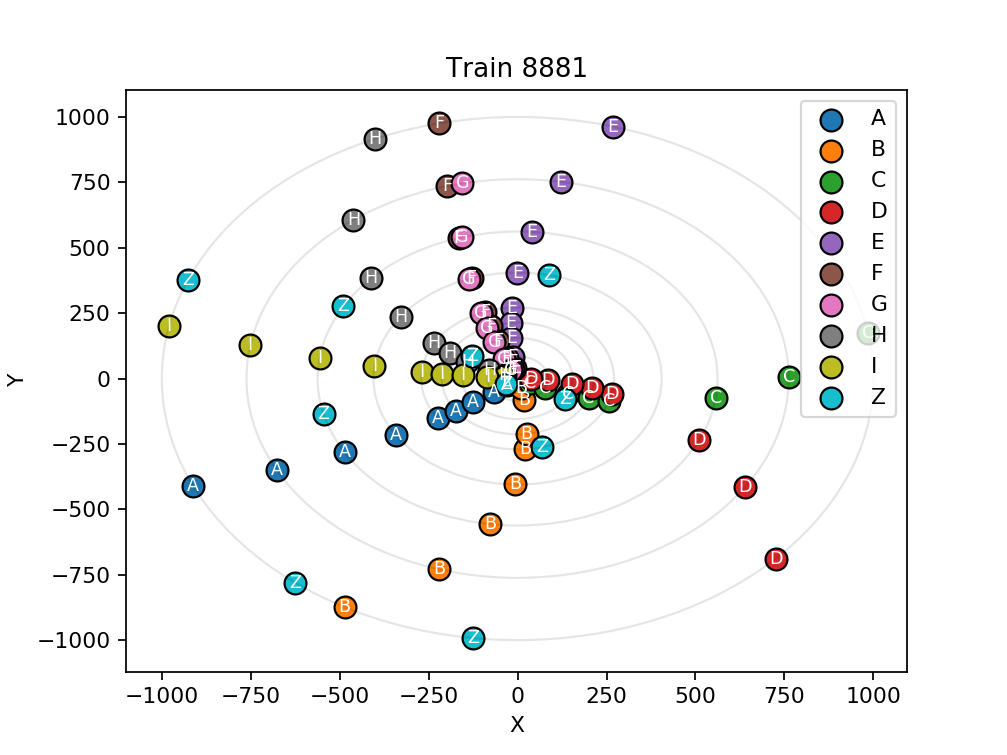

In [5]:
n = 8881 #np.random.randint(len(train))
print("Train {}".format(n))
print("Number of Hits: {}".format(metrics.number_of_hits(train[n])))
print("Number of Tracks: {}".format(metrics.number_of_tracks(train[n])))
visuals.Plot2D(train[n], order).plot(mode="xy", title="Train {}".format(n))

In [6]:
print(n)
visuals.display(train[n], order)

8881


,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-2.895529,562.0,-80.662152,,,,,,,,,,,,,,,,,,,,,,,,,,1,
1,-2.719777,1000.0,-48.289718,1,,,,,,,,,,,,,,,,,,,,,,,,,,
2,-2.663688,762.0,-36.796765,1,,,,,,,,,,,,,,,,,,,,,,,,,,
3,-2.615846,562.0,-27.138822,1,,,,,,,,,,,,,,,,,,,,,,,,,,
4,-2.577248,405.0,-19.557336,1,,,,,,,,,,,,,,,,,,,,,,,,,,
5,-2.546779,39.0,117.754959,,,,,,,,,,,,,,,,,,,,,,,,,,1,
6,-2.543667,271.0,-13.086514,1,,,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.527406,213.0,-10.285710,1,,,,,,,,,,,,,,,,,,,,,,,,,,
8,-2.509782,155.0,-7.484906,1,,,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.485555,85.0,-4.104626,1,,,,,,,,,,,,,,,,,,,,,,,,,,


### Create the model.

In [7]:
input_shape  = (235, 3)
n_categories = 25 + 2
optimizer    = keras.optimizers.RMSprop(lr=0.001)
histories    = []

In [8]:
# If you have already created a model, run this cell to load the model.
# Else, just run the cell below this cell.
model = keras.models.load_model(modelpath)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
model = Sequential()
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul",
    input_shape=input_shape))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(Bidirectional(
    GRU(units=256, return_sequences=True, recurrent_dropout=1/2, implementation=2),
    merge_mode="mul"))
model.add(Dropout(rate=1/2))
model.add(TimeDistributed(Dense(units=n_categories, kernel_initializer="uniform", activation="softmax")))
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

### Fit the model.

In [20]:
%%time
#64
epochs     = 20
batch_size = 100
histories.append(model.fit_generator(
    ext.input_output_generator(train, batch_size, order),
    steps_per_epoch=len(train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=ext.input_output_generator(test, batch_size, order),
    validation_steps=len(test) // batch_size,
    callbacks=[
        keras.callbacks.ModelCheckpoint(
            filepath=modelpath,
            save_best_only=True,
            verbose=0,),
    keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)]))

Epoch 1/20
250/250 [==============================] - 357s - loss: 0.4107 - acc: 0.8710 - val_loss: 0.1988 - val_acc: 0.9433
Epoch 2/20
250/250 [==============================] - 354s - loss: 0.4109 - acc: 0.8711 - val_loss: 0.1926 - val_acc: 0.9444
Epoch 3/20
250/250 [==============================] - 353s - loss: 0.4081 - acc: 0.8721 - val_loss: 0.1920 - val_acc: 0.9450
Epoch 4/20
250/250 [==============================] - 351s - loss: 0.4091 - acc: 0.8715 - val_loss: 0.1994 - val_acc: 0.9430
Epoch 5/20
250/250 [==============================] - 350s - loss: 0.4075 - acc: 0.8722 - val_loss: 0.1938 - val_acc: 0.9443
Epoch 6/20
250/250 [==============================] - 350s - loss: 0.4081 - acc: 0.8720 - val_loss: 0.1965 - val_acc: 0.9430
Epoch 7/20
249/250 [============================>.] - ETA: 1s - loss: 0.4078 - acc: 0.8722
Epoch 00006: reducing learning rate to 0.00010000000474974513.
250/250 [==============================] - 350s - loss: 0.4075 - acc: 0.8723 - val_loss: 0.1924 

### Display information about the model after fitting it.

In [28]:
%%time
guesses          = model.predict(ext.extract_input(test, order))
hits_correct     = metrics.percent_of_hits_assigned_correctly(test, guesses=guesses, order=order)
tracks_correct   = metrics.percent_of_tracks_assigned_correctly(test, guesses=guesses, order=order, percent=1.0)
n_tracks_correct = metrics.percent_of_events_with_correct_number_of_tracks(test, guesses=guesses, order=order)
print("Percent of hits assigned correctly: {}%".format(hits_correct * 100))
print("Percent of tracks assigned correctly: {}%".format(tracks_correct * 100))
print("Percent of events with the correct number of tracks: {}%".format(n_tracks_correct * 100))

Percent of hits assigned correctly: 86.2501160801747%
Percent of tracks assigned correctly: 63.48609876856671%
Percent of events with the correct number of tracks: 83.05555555555556%
CPU times: user 1min 20s, sys: 44 ms, total: 1min 20s
Wall time: 1min 20s


### Display how one of the model's predictions looks.

Percent of hits assigned correctly: 92.5531914893617%
Percent of tracks assigned correctly: 63.63636363636363%


<IPython.core.display.Javascript object>


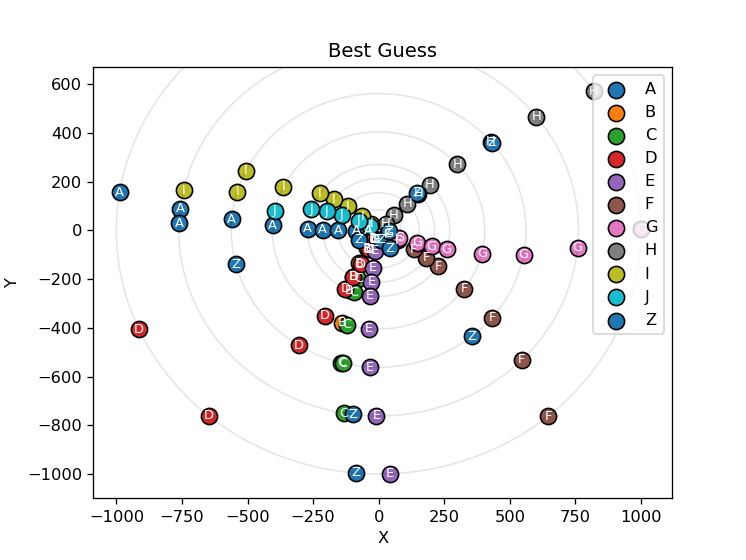

<IPython.core.display.Javascript object>


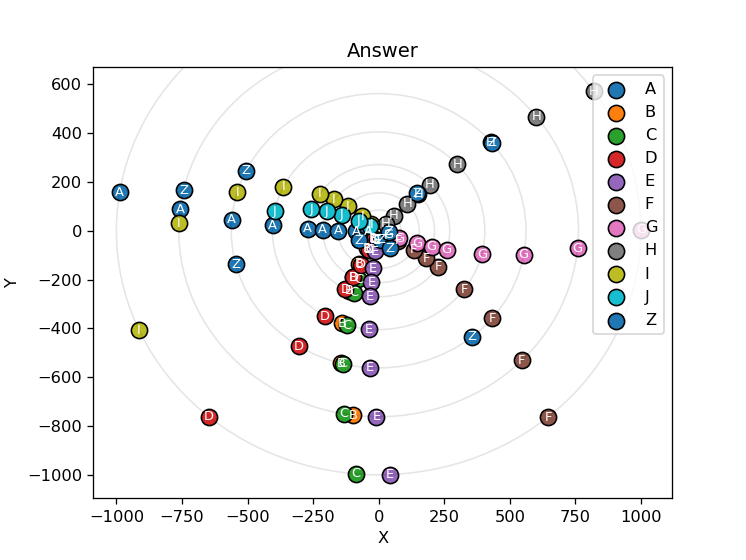

In [29]:
n  = np.random.randint(len(test))
print("Percent of hits assigned correctly: {}%".format(
    metrics.percent_of_hits_assigned_correctly(test[n], guesses[n], order) * 100))
print("Percent of tracks assigned correctly: {}%".format(
    metrics.percent_of_tracks_assigned_correctly(test[n], guesses[n], order) * 100))
d = visuals.Plot2D(test[n], order, guesses[n]).plot(mode="xy", title="Best Guess")
d = visuals.Plot2D(test[n], order).plot(mode="xy", title="Answer")

<IPython.core.display.Javascript object>


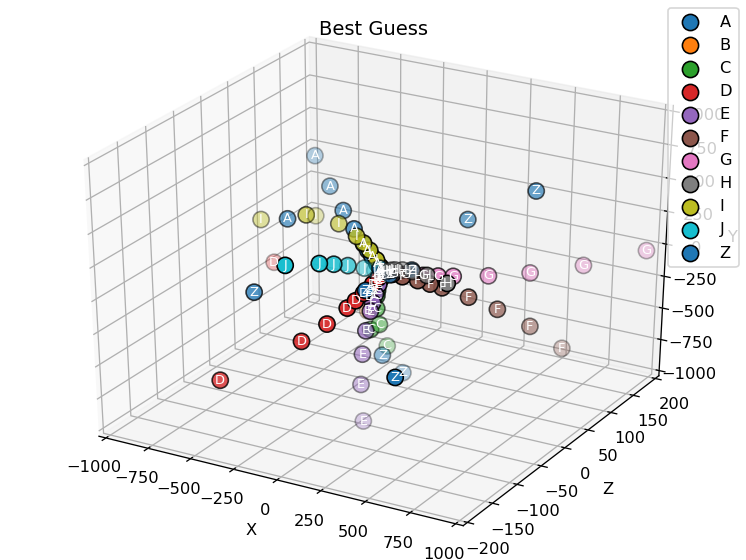

<IPython.core.display.Javascript object>


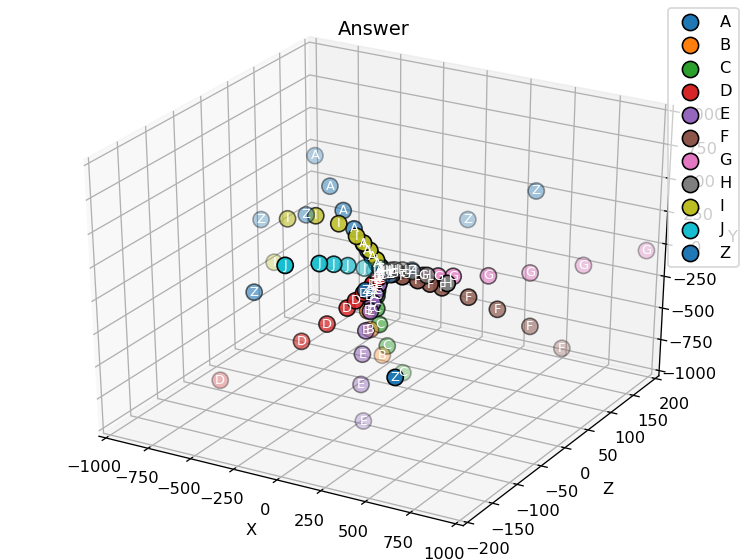

In [30]:
d = visuals.Plot3D(test[n], order, guesses[n]).plot(title="Best Guess")
d = visuals.Plot3D(test[n], order).plot(title="Answer")

In [31]:
visuals.display(test[n], order, guesses[n], mode="discrete pairs")

,phi,r,z,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,noise,pad
0,-3.127622,85.0,16.911459,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
1,-3.103132,39.0,7.759375,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,,
2,-2.893221,562.0,-68.142689,,,,,,,,,,,,,,,,,,,,,,,,,,`1`[1],
3,-2.722644,1000.0,89.706927,,,,`0`[1],,,,,`1`[0],,,,,,,,,,,,,,,,,,
4,-2.664353,85.0,19.564190,,,,,,,,,,,,,,,,,,,,,,,,,,`1`[1],
5,-2.275395,1000.0,-103.505780,,,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,
6,-2.148667,39.0,1.619917,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,
7,-2.143119,562.0,-58.170248,,,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,
8,-2.115277,85.0,3.530588,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,,,
9,-2.097523,405.0,-41.919841,,,,`1`[1],,,,,,,,,,,,,,,,,,,,,,,


### Display the graphs.

<IPython.core.display.Javascript object>


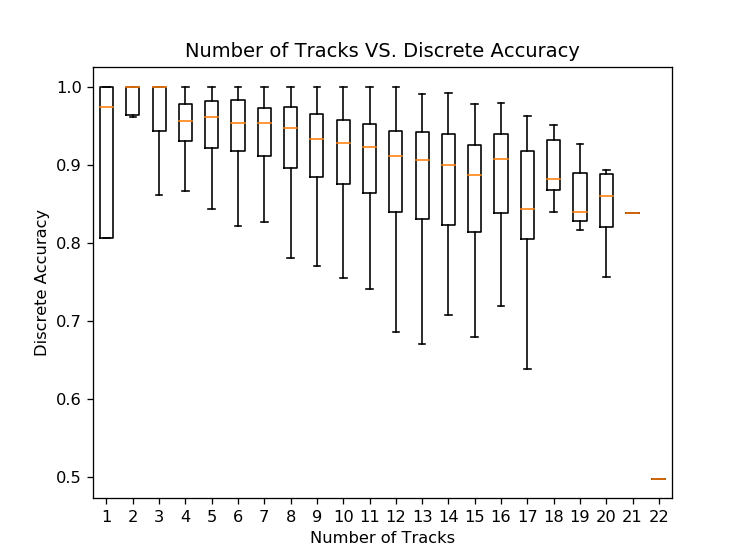

CPU times: user 28.1 s, sys: 4 ms, total: 28.1 s
Wall time: 28.1 s


In [32]:
%%time
n_tracks, accuracy = metrics.accuracy_vs_tracks(test, guesses, order)
r = range(n_tracks.min(), n_tracks.max() + 1)
boxes = [[] for _ in r]
for i in range(len(n_tracks)):
    boxes[n_tracks[i] - n_tracks.min()].append(accuracy[i])
visuals.boxplot(boxes, "Number of Tracks VS. Discrete Accuracy", "Number of Tracks", "Discrete Accuracy", xticks=list(r))